# RFM Analysis and K-means Clustering for Customer Segmentation

 **RFM Analysis:**
 1. Metrics:
 - Recency: Days since the last purchase (lower is better).
 - Frequency: Total number of purchases (higher is better).
 - Monetary: Total spending (higher is better).

 2. Scoring:
 - Customers are scored on R, F, and M metrics, divided into 4 quartiles (1=low, 4=high).
 - RFM_Segment combines R, F, and M scores (e.g., '444' indicates top-tier customers).
 - RFM_Score (sum of R, F, and M scores) ranks customers overall (max=12).

 **K-means Clustering:**
 1. Data Scaling:
 - StandardScaler is used to standardize RFM data for equal weighting.

 2. Elbow Method:
 - Determines the optimal number of clusters (k=4) by identifying the "elbow point" on the inertia plot.

 3. Clustering:
 - K-means groups customers into 4 clusters based on RFM metrics.
 - Cluster labels are added to the RFM table.

 4. Visualization:
 - Scatter plot of Frequency vs. Monetary shows clusters color-coded by purchasing behavior.

# Business Insights:
 1. High-Value Customers (Cluster 3):
 - Frequent purchases and high spending; retain with VIP programs and personalized offers.

 2. Budget Buyers (Cluster 0):
 - Low frequency and spending; re-engage with promotions and discounts.

 3. Regular Shoppers (Cluster 1):
 - Moderate frequency and spending; strengthen loyalty through rewards programs.

 4. High Frequency, Low Spending (Cluster 2):
 - Frequent shoppers with lower spending; increase revenue through upselling or cross-selling.

# Strategic Recommendations:
 - Focus retention efforts on high-value customers (Cluster 3).
 - Target low-value clusters (0, 1) with re-engagement campaigns.
 - Monitor and periodically re-cluster to adapt to customer behavior changes.


In [ ]:
import pandas as pd
from datetime import datetime

customers = pd.read_csv('Cleaned_Customers.csv')
transactions = pd.read_csv('Cleaned_Transactions.csv')

transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

latest_date = transactions['TransactionDate'].max() + pd.DateOffset(days=1)
rfm_table = transactions.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (latest_date - x.max()).days,  # Recency
    'TransactionID': 'count',  # Frequency
    'TotalValue': 'sum'  # Monetary
}).rename(columns={'TransactionDate': 'Recency',
                   'TransactionID': 'Frequency',
                   'TotalValue': 'Monetary'})

rfm_table['R_Score'] = pd.qcut(rfm_table['Recency'], 4, ['4', '3', '2', '1'])
rfm_table['F_Score'] = pd.qcut(rfm_table['Frequency'], 4, ['1', '2', '3', '4'])
rfm_table['M_Score'] = pd.qcut(rfm_table['Monetary'], 4, ['1', '2', '3', '4'])
rfm_table['RFM_Segment'] = rfm_table['R_Score'].astype(str) + rfm_table['F_Score'].astype(str) + rfm_table['M_Score'].astype(str)
rfm_table['RFM_Score'] = rfm_table[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

print(rfm_table.sort_values(by='RFM_Score', ascending=False).head(10))


            Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Segment  \
CustomerID                                                                     
C0143            10          7   6044.63       4       4       4         444   
C0099             5          8   6715.72       4       4       4         444   
C0165             3          9   6708.10       4       4       4         444   
C0075            18          9   5848.97       4       4       4         444   
C0041            13          7   6149.78       4       4       4         444   
C0122            11          7   5072.55       4       4       4         444   
C0051            12          7   5699.57       4       4       4         444   
C0028             4          8   6819.57       4       4       4         444   
C0101             1          8   5550.99       4       4       4         444   
C0012             4          7   5231.26       4       4       4         444   

           RFM_Score  
CustomerID      

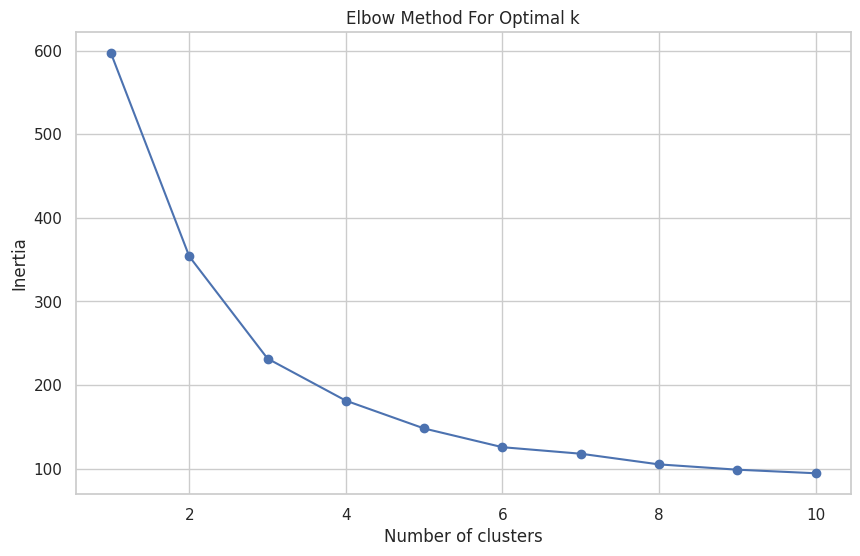

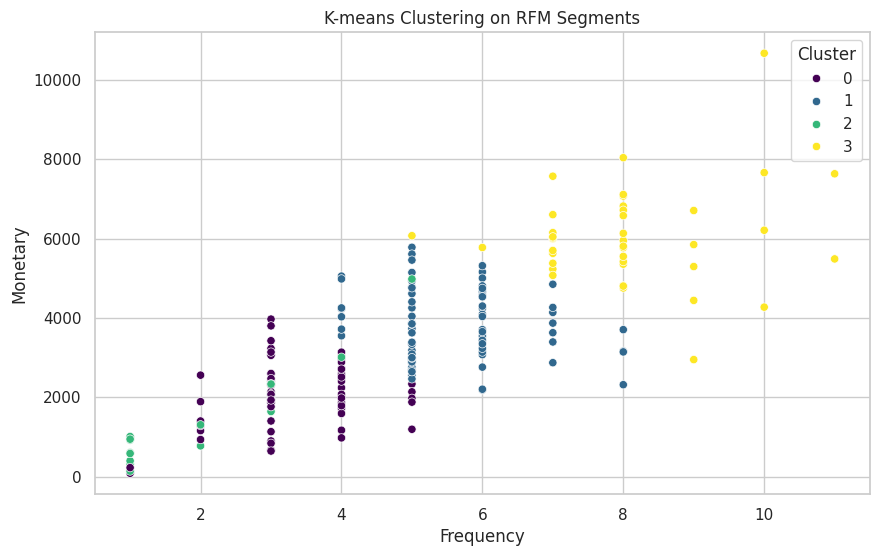

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_table[['Recency', 'Frequency', 'Monetary']])

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=4, random_state=1)
clusters = kmeans.fit_predict(rfm_scaled)
rfm_table['Cluster'] = clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', data=rfm_table, palette='viridis', legend='full')
plt.title('K-means Clustering on RFM Segments')
plt.show()


# Lookalike Model - Approach and Thought Process

 1. Feature Engineering:
 - Monetary: Total spending by a customer (indicates value).
 - Frequency: Number of transactions made (indicates engagement).
 - Recency: Days since the last transaction (indicates recent activity).

 2. Data Standardization:
 - StandardScaler ensures Monetary, Frequency, and Recency are on the same scale to contribute equally to similarity calculations.

 3. Weighted Features:
 - Weights: 0.4 for Monetary and Frequency (high priority) and 0.2 for Recency (lower priority).
 - Reflects business priorities by emphasizing high-value and frequent buyers.

 4. Dimensionality Reduction:
 - PCA reduces the features to two components while retaining variance.
 - Simplifies similarity computation and aids visualization.

 5. Cosine Similarity:
 - Measures the similarity of customers based on their behavioral patterns in the feature space.
 - Ideal for high-dimensional data as it evaluates direction, not magnitude.

 6. Generating Lookalikes:
 - For each customer, the top 3 most similar customers are identified based on cosine similarity scores.
 - Results saved in a CSV file (`Lookalike.csv`) for further use.

# Business Advantages:
 - Enables targeted marketing by identifying similar customer groups.
 - Helps upsell and cross-sell by recommending products popular with similar customers.
 - Scalable and customizable with adjustable feature weights to align with business needs.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

customers = pd.read_csv('Cleaned_Customers.csv')
products = pd.read_csv('Cleaned_Products.csv')
transactions = pd.read_csv('Cleaned_Transactions.csv')

transactions = transactions.merge(customers, on='CustomerID', how='left')
transactions = transactions.merge(products, on='ProductID', how='left')

total_spending = transactions.groupby('CustomerID')['TotalValue'].sum().reset_index()
total_spending.rename(columns={'TotalValue': 'Monetary'}, inplace=True)

frequency = transactions.groupby('CustomerID')['TransactionID'].count().reset_index()
frequency.rename(columns={'TransactionID': 'Frequency'}, inplace=True)

latest_date = pd.to_datetime(transactions['TransactionDate']).max()
recency = transactions.groupby('CustomerID')['TransactionDate'].max().reset_index()
recency['TransactionDate'] = pd.to_datetime(recency['TransactionDate'])
recency['Recency'] = (latest_date - recency['TransactionDate']).dt.days
recency = recency[['CustomerID', 'Recency']]

features = total_spending.merge(frequency, on='CustomerID')
features = features.merge(recency, on='CustomerID')

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features[['Monetary', 'Frequency', 'Recency']])

weights = np.array([0.4, 0.4, 0.2])
weighted_features = scaled_features * weights

pca = PCA(n_components=2)
pca_features = pca.fit_transform(weighted_features)

similarity_matrix = cosine_similarity(pca_features)

similarity_df = pd.DataFrame(similarity_matrix, index=features['CustomerID'], columns=features['CustomerID'])

def get_top_lookalikes(similarity_df, cust_id, num_lookalikes=3):
    scores = similarity_df.loc[cust_id].sort_values(ascending=False)[1:num_lookalikes+1]
    return scores.to_dict()

first_20_customers = features['CustomerID'].iloc[:20]
lookalike_results = {
    cust: get_top_lookalikes(similarity_df, cust) for cust in first_20_customers
}

lookalike_df = pd.DataFrame(list(lookalike_results.items()), columns=['CustomerID', 'Lookalikes'])
lookalike_df.to_csv('Lookalike.csv', index=False)

print("Lookalike model execution complete. Results saved to Lookalike.csv.")


Lookalike model execution complete. Results saved to Lookalike.csv.


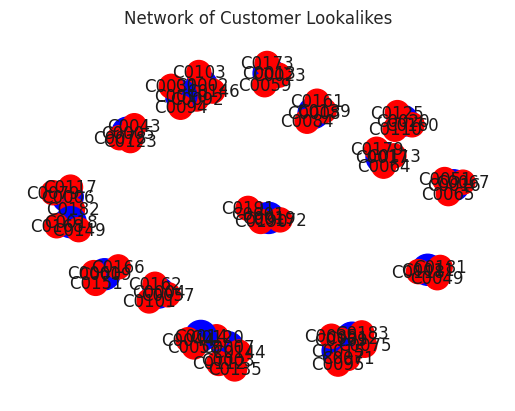

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

lookalike_df = pd.read_csv('Lookalike.csv')

G = nx.Graph()

for index, row in lookalike_df.iterrows():
    main_customer = row['CustomerID']
    lookalikes = eval(row['Lookalikes'])
    for cust, score in lookalikes.items():
        G.add_node(main_customer, color='blue', size=500)  # Main customer node
        G.add_node(cust, color='red', size=300)  # Lookalike customer node
        G.add_edge(main_customer, cust, weight=score)

pos = nx.spring_layout(G, seed=42)

node_color = [nx.get_node_attributes(G, 'color')[node] for node in G]
node_size = [nx.get_node_attributes(G, 'size')[node] for node in G]
nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_size)

weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, alpha=0.5, width=weights)

nx.draw_networkx_labels(G, pos)

plt.title('Network of Customer Lookalikes')
plt.axis('off')  # Turn off the axis
plt.show()
